# Analyses of Iterative Reweighting on the L21 norm

In [127]:
import numpy as np 
from scipy.sparse import random as sprandn
import matplotlib.pyplot as plt

We implement the same algorithms as before but the only difference includes adding a weighting factor that varies per iteration. This weighting is provably optimal in improving our output. However, the results in this test do not indicate a strong response to the weighting.

Text(0.5,1,'Clean Artificial Plot of Brain Source Activity')

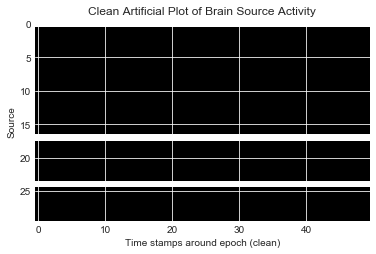

In [133]:
m = 30 	#number of sources
k = 10 # number of sensors
m_ = float(m)
n = 50 # number of time stamps around each epoch
A_ = np.matrix(np.random.randn(k,m)) # defining a random A
A_ = (A_-np.mean(A_,0))/np.std(A_,0) # normalize columns at each time instant.
X_r = [np.random.uniform(0,1,m) < 3.0/m]
X = np.tile(X_r, (n,1))
X = X.T
X = X.astype(int)
plt.style.use('seaborn-darkgrid')
plt.imshow(X, cmap = "gray")
plt.xlabel("Time stamps around epoch (clean)")
plt.ylabel("Source")
plt.title("Clean Artificial Plot of Brain Source Activity")

The code below generates the noisy signal to model the sensor output in non-invasive processes. The goal would be to recreate the above image using the understanding of sparsity and its structure in this context.

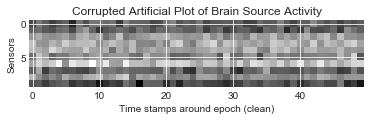

In [134]:
B = A_*X + np.sqrt(1.0)*np.matrix(np.random.randn(k,n)) # creating the O/P
plt.imshow(B, cmap = "gray")
plt.xlabel("Time stamps around epoch (clean)")
plt.ylabel("Sensors")
plt.title("Corrupted Artificial Plot of Brain Source Activity")
# cached computations: these don't need to be repeatedly computed for comparison

maxit = 100
V = 1e-4
W = 1e-2 #error tolerance for ADMM

Now we create some special functions to vectorize the matrices to vectors that are easier to work with.

In [135]:
b = B.T.reshape(k*n,1)
A = np.kron(np.eye(n), A_)
ATA = A.T*A
ATb = A.T*b

## The construction of various models and their hyperparameters
The parameters are obtained from literature and/or commonsense. The parameters are kept constant across models when possible. Also we implement the proximal operator from scratch. Note that this can in fact be vectorized so our implementation from the previous section can be used. The L21 norm requires careful 2-norm along space and 1-norm across time.

In [136]:
def switch(x):
    X = x.reshape(n,m).T
    return X

def l21(x):
    X = switch(x)
    sumo = 0.0
    for i in range(m):
        sumt = 0.0
        for j in range(n):
            sumt = sumt + X[i,j]*X[i,j]
        sumo = sumo + np.sqrt(sumt)
    return sumo

def objective(A,x,b,gamma):
    return f(A,x,b) + gamma*l21(x)

def objective_r(A,x,b,gamma,w):
    return f(A,x,b) + gamma*l21_r(x,w)

def f(A,x,b):
    return 0.5*(np.linalg.norm(A*x-b)**2)

def gradf(ATA,x,ATb):
    return ATA*x-ATb 

def uppbd(A,ATA,ATb,x,x_1,b,lK):
    xd = x_1 - x
    return f(A,x,b) + 1.0/(2.0*lK)* np.sum(np.multiply(xd,xd)) + gradf(ATA,x,ATb).T*xd 
    
# def proxop(zeta,lamdaK):
#     f = np.matrix(np.zeros(np.shape(zeta)))
#     return np.multiply(np.sign(zeta),np.maximum(np.abs(zeta)-lamdaK,f))
def proxop(zeta,lamdaK):
    Z = switch(zeta)
    q = np.matrix(np.zeros((np.shape(zeta)[0],1)))
    for i in range(0,len(zeta)):
        d = i/n
        q[i,0] = zeta[i,0]*np.maximum(0,1 - lamdaK/np.linalg.norm(Z[d,:]))
    return q

def l21_r(x,w):
    X = switch(x)
    sumo = 0.0
    for i in range(m):
        sumt = 0.0
        for j in range(n):
            sumt = sumt + w[i,0]*X[i,j]*X[i,j]
        sumo = sumo + np.sqrt(sumt)
    return sumo

### Defining the Convergence Algorithm for comparison

In [170]:
def PGD_r(maxit,lK,g,AtA,Atb,A,beta,b,V):
    eps = 0.1
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    w = np.matrix(np.ones((m,1)))
    obj = []
    for k in range(maxit):
        while True:
            xr = proxop(x-lK*gradf(AtA,x,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,x,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective_r(A,xr,b,g,w))
        if k > 1 and np.linalg.norm(objective_r(A,xr,b,g,w) - objective_r(A,x,b,g,w)) < V:
            break
        x = xr
        Bet = switch(x)
        
        for i in range(0, m):
            w[i,0] = 1 / 5*(np.linalg.norm(Bet[i,:]) + eps)
    return obj,xr

def PGD(maxit,lK,g,AtA,Atb,A,beta,b,V):
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    obj = []
    for k in range(maxit):
        while True:
            xr = proxop(x-lK*gradf(AtA,x,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,x,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective(A,xr,b,g))
        if k > 1 and np.linalg.norm(objective(A,xr,b,g) - objective(A,x,b,g)) < V:
            break
        x = xr
    return obj,xr

### Running the Defined Solvers

In [171]:
lK = 1
be = 0.5
g =  0.01

obj3,d = PGD(maxit,lK,g,ATA,ATb,A,be,b,V)
obj4,d2 = PGD_r(maxit,lK,g,ATA,ATb,A,be,b,V)

print

### Plotting the Convergence Graphs per method

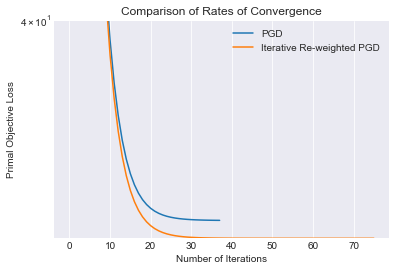

In [178]:
plt.plot(range(len(obj3)), obj3, range(len(obj4)), obj4)
plt.title('Comparison of Rates of Convergence')
plt.yscale('log')
plt.ylim(0,40)
plt.xlabel('Number of Iterations')
plt.ylabel('Primal Objective Loss')
plt.legend(['PGD','Iterative Re-weighted PGD'])

### Verifying the performance of these convergence methods with a soft thresholding to emphasize solutions

Text(0.5,1,'Reconstructed Source Signal')

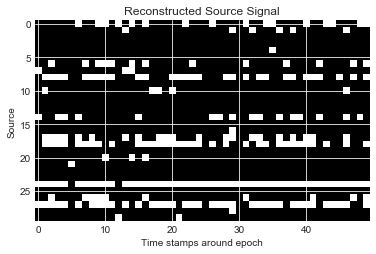

In [164]:
X_res = switch(d)
plt.imshow(X_res > 0.2, cmap = "gray")
plt.xlabel("Time stamps around epoch")
plt.ylabel("Source")
plt.title("Reconstructed Source Signal")

Text(0.5,1,'Reconstructed Source Signal')

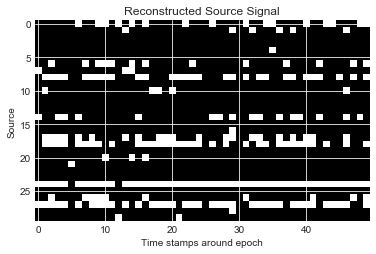

In [165]:
X_res = switch(d2)
plt.imshow(X_res > 0.2, cmap = "gray")
plt.xlabel("Time stamps around epoch")
plt.ylabel("Source")
plt.title("Reconstructed Source Signal")